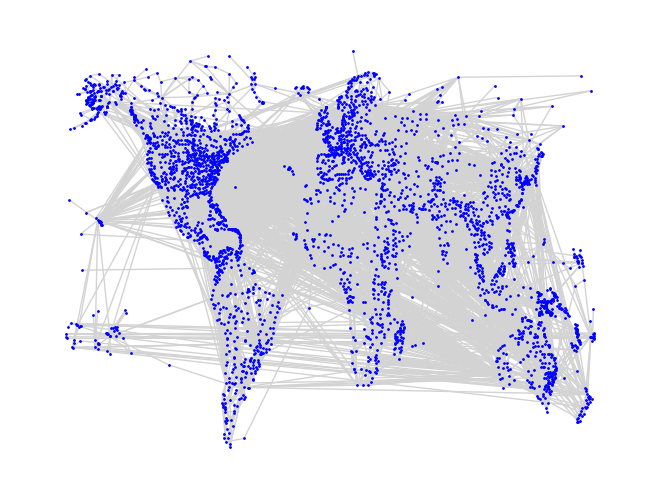

In [179]:
from utils import load, plot

graph = load.load_graphml("dataset/airportsAndCoordAndPop.graphml")
pos = {node: (graph.nodes[node]["lon"], graph.nodes[node]["lat"]) for node in graph.nodes}

kwargs = {
    "pos": pos,
    "node_size": 1,
    "node_color": "blue",
    "edge_color": "lightgray",
    "with_labels": False,
}
plot.plot_graph(graph, **kwargs)


In [180]:
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

## 1. Démarrer

Vérifier que vous êtes capables d'entrainer sur ce réseau l'un des GCN simples que vous avez écrit lors du premier TP.

In [181]:
# PREPARE DATA
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelEncoder
import torch

# Keep country that have at least 50 airports
min_nb_airport = 50

def filter_graph(graph, min_nb_airport=0):
    countries = set([graph.nodes[node]["country"] for node in graph.nodes])
    countries = {country: sum([1 for node in graph.nodes if graph.nodes[node]["country"] == country]) for country in countries}
    graph = graph.subgraph([node for node in graph.nodes if countries[graph.nodes[node]["country"]] >= min_nb_airport])
    return graph

def convert_data(graph, train_ratio=0.8):
    
    # Transform the networkx graph to a PyG Data object 
    data: Data = from_networkx(graph, group_node_attrs=["lon", "lat"])

    # encode country labels to integers
    encoder = LabelEncoder()
    integer_labels = encoder.fit_transform(data.country)

    # Set the target tensor
    target_tensor = torch.tensor(integer_labels, dtype=torch.long)
    data.y = target_tensor
    data.num_classes = len(encoder.classes_)

    # Split the data into train and test
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[:int(data.num_nodes*train_ratio)] = 1
    test_mask[int(data.num_nodes*train_ratio):] = 1
    data.train_mask = train_mask
    data.test_mask = test_mask

    # Set the node features
    data.x = torch.tensor(data.x, dtype=torch.float)
    
    return data

def shuffle_data(data):
    """Shuffles the nodes in a torch_geometric.data.Data object.

    Args:
        data: The Data object to be shuffled.

    Returns:
        A new Data object with shuffled nodes.
    """
    num_nodes = data.num_nodes
    permutation = torch.randperm(num_nodes) 

    # Shuffle node-level attributes (numerical and boolean)
    x = data.x[permutation]
    y = data.y[permutation]
    train_mask = data.train_mask[permutation]
    test_mask = data.test_mask[permutation]
    population = data.population[permutation]

    # Adjust edge_index to maintain connections after shuffling
    edge_index = data.edge_index
    for i in range(edge_index.size(1)):  # Iterate over each edge
        for j in range(edge_index.size(0)):  # Iterate over source and destination nodes
            edge_index[j, i] = permutation[edge_index[j, i]]

    # Create a new Data object with shuffled attributes
    shuffled_data = Data(
        x=x,
        edge_index=edge_index,
        y=y,
        train_mask=train_mask,
        test_mask=test_mask,
        population=population,
        country=data.country,  # Keep original order
        city_name=data.city_name,  # Keep original order
        num_classes=data.num_classes  # num_classes remains unchanged
    )
    return shuffled_data




In [182]:
graph = load.load_graphml("dataset/airportsAndCoordAndPop.graphml")
graph = filter_graph(graph, min_nb_airport=min_nb_airport)
data = convert_data(graph, train_ratio=0.8)
data = shuffle_data(data)

print(f"""
{data}

Nodes: {data.num_nodes}
Edges: {data.num_edges}

Node Features: {data.num_node_features}
Edge Features: {data.num_edge_features}

Classes: {data.num_classes}

""")



Data(x=[1758, 2], edge_index=[2, 11914], y=[1758], train_mask=[1758], test_mask=[1758], population=[1758], country=[1758], city_name=[1758], num_classes=12)

Nodes: 1758
Edges: 11914

Node Features: 2
Edge Features: 0

Classes: 12




/tmp/ipykernel_63617/1071483039.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.x = torch.tensor(data.x, dtype=torch.float)


In [183]:
# Define a simple GCN model

import torch
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dim_in, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_out)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)
    
    
    def fit(self, data, epochs=100, lr=0.01):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=5e-4)
        loss_fct = torch.nn.CrossEntropyLoss()

        evol_acc = []
        evol_loss = []
        
        self.train()
        for e in range(epochs):     
            optimizer.zero_grad()
            out = self(data)
            loss = loss_fct(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            acc = self.accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            optimizer.step()
            
            evol_acc.append(acc)
            evol_loss.append(loss.item())
                
            print(f"Epoch {e+1}/{epochs} - Loss: {loss.item():.4f} - Acc: {acc:.4f}", end="\r")
        return evol_acc, evol_loss

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data)
        acc = self.accuracy(out[data.test_mask].argmax(dim=1), data.y[data.test_mask])
        return acc
            
    def predict(self, data):
        self.eval()
        with torch.no_grad():
            out = self(data)
            return out.argmax(dim=1)
        
    def accuracy(self, pred, target):
        correct = pred.eq(target).sum().item()
        return correct / target.size(0)


/tmp/ipykernel_63617/1071483039.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.x = torch.tensor(data.x, dtype=torch.float)


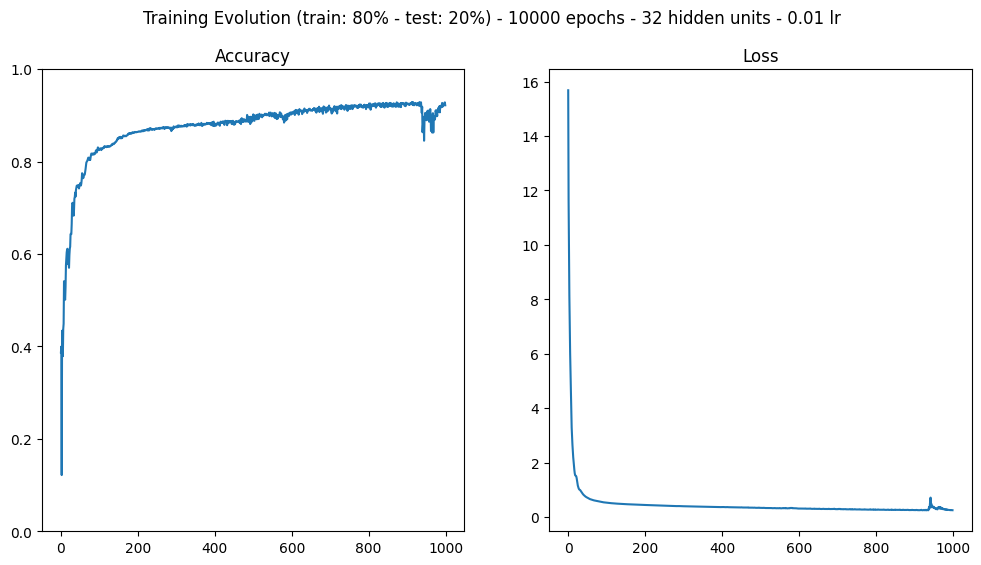

In [184]:
import matplotlib.pyplot as plt

NB_AIRPORTS = 40
graph = load.load_graphml("dataset/airportsAndCoordAndPop.graphml")
graph = filter_graph(graph, min_nb_airport=NB_AIRPORTS)
data = convert_data(graph, train_ratio=0.8)
# data = shuffle_data(data)



# CREATE MODEL & TRAIN
model = GCN(data.num_node_features,  16, data.num_classes)
evol_acc, evol_loss = model.fit(data, epochs=1000, lr=0.01)

plt.figure(figsize=(12, 6))
plt.suptitle("Training Evolution (train: 80% - test: 20%) - 10000 epochs - 32 hidden units - 0.01 lr")
plt.subplot(1, 2, 1)
plt.plot(evol_acc)
plt.ylim([0, 1])
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(evol_loss)
plt.title("Loss")

plt.show()

In [185]:
# display the test accuracy
acc = model.test(data)
print(f"Test Accuracy: {acc}")

Test Accuracy: 0.8835443037974684


<Axes: >

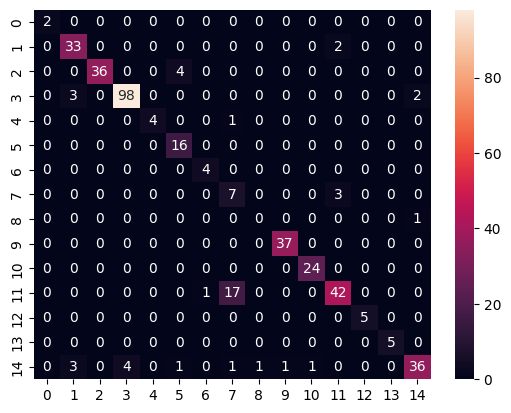

In [186]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = model.predict(data)
confmat = confusion_matrix(data.y[data.test_mask], pred[data.test_mask])
sns.heatmap(confmat, annot=True, fmt='g')

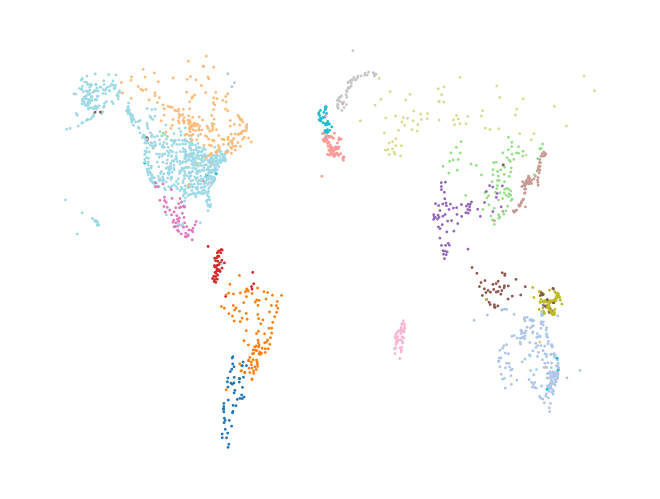

In [190]:
# plot the prediction
graph = load.load_graphml("dataset/airportsAndCoordAndPop.graphml")
graph = filter_graph(graph, min_nb_airport=NB_AIRPORTS)

pred = model.predict(data)
kwargs["node_color"] = pred.numpy()
kwargs["cmap"] = "tab20"
kwargs["node_size"] = 1
kwargs["edge_color"] = "white"
plot.plot_graph(graph, **kwargs)
plt.show()